In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
!pip install torchmetrics
import torchmetrics
!pip install pytorch_lightning
from sklearn.metrics import classification_report
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
!pip install torchinfo
from torchinfo import summary
!pip install vit_pytorch
from vit_pytorch.vit_for_small_dataset import ViT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 8.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 7.4 MB/s 
     |████████████████████████████████| 596 kB 68.0 MB/s 
     |████████████████████████████████| 140 kB 73.6 MB/s 
     |████████████████████████████████| 1.1 MB 52.6 MB/s 
     |████████████████████████████████| 144 kB 83.8 MB/s 
     |████████████████████████████████| 271 kB 87.9 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [ ]:
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def load_file(path):
  return Image.open(path)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = torchvision.datasets.DatasetFolder(
    root="/content/drive/MyDrive/breast_new/40x/test",
    loader=load_file, extensions="png", transform=transform)

In [ ]:
train_dataset = torchvision.datasets.DatasetFolder(
    root="/content/drive/MyDrive/breast_new/40x/train",
    loader=load_file, extensions="png", transform=transform)

val_dataset = torchvision.datasets.DatasetFolder(
    root="/content/drive/MyDrive/breast_new/40x/val",
    loader=load_file, extensions="png", transform=transform)

test_dataset = torchvision.datasets.DatasetFolder(
    root="/content/drive/MyDrive/breast_new/40x/test",
    loader=load_file, extensions="png", transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


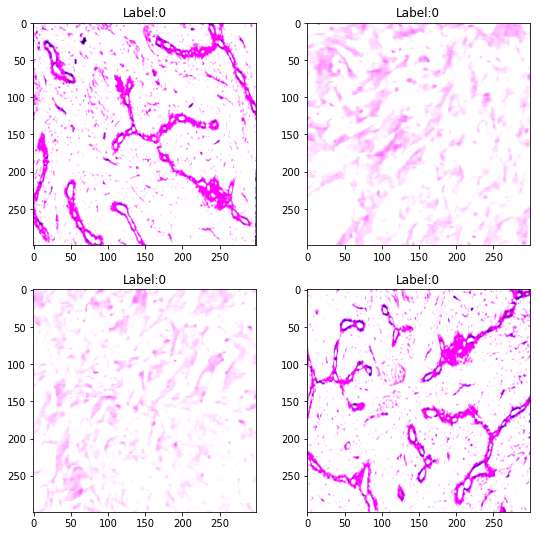

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(500, 1000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray.permute(1, 2, 0))
        axis[i][j].set_title(f"Label:{label}")

In [ ]:
batch_size = 1#TODO
num_workers = 2# TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images, {len(val_dataset)} val images and {len(test_dataset)} test images")

There are 16186 train images, 321 val images and 389 test images


In [ ]:
model_inception_v3 = torchvision.models.inception_v3(pretrained=True, aux_logits=False)
summary(model_inception_v3)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Param #
Inception3                               --
├─BasicConv2d: 1-1                       --
│    └─Conv2d: 2-1                       864
│    └─BatchNorm2d: 2-2                  64
├─BasicConv2d: 1-2                       --
│    └─Conv2d: 2-3                       9,216
│    └─BatchNorm2d: 2-4                  64
├─BasicConv2d: 1-3                       --
│    └─Conv2d: 2-5                       18,432
│    └─BatchNorm2d: 2-6                  128
├─MaxPool2d: 1-4                         --
├─BasicConv2d: 1-5                       --
│    └─Conv2d: 2-7                       5,120
│    └─BatchNorm2d: 2-8                  160
├─BasicConv2d: 1-6                       --
│    └─Conv2d: 2-9                       138,240
│    └─BatchNorm2d: 2-10                 384
├─MaxPool2d: 1-7                         --
├─InceptionA: 1-8                        --
│    └─BasicConv2d: 2-11                 --
│    │    └─Conv2d: 3-1                  12,288
│   

In [ ]:
for param in model_inception_v3.parameters():
  param.requires_grad = False

In [ ]:
def get_learnable_parameters(model):
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

In [ ]:
model_inception_v3.fc = nn.Linear(model_inception_v3.fc.in_features, 5)

model_inception_v3.to(device)
summary(model_inception_v3)

Layer (type:depth-idx)                   Param #
Inception3                               --
├─BasicConv2d: 1-1                       --
│    └─Conv2d: 2-1                       (864)
│    └─BatchNorm2d: 2-2                  (64)
├─BasicConv2d: 1-2                       --
│    └─Conv2d: 2-3                       (9,216)
│    └─BatchNorm2d: 2-4                  (64)
├─BasicConv2d: 1-3                       --
│    └─Conv2d: 2-5                       (18,432)
│    └─BatchNorm2d: 2-6                  (128)
├─MaxPool2d: 1-4                         --
├─BasicConv2d: 1-5                       --
│    └─Conv2d: 2-7                       (5,120)
│    └─BatchNorm2d: 2-8                  (160)
├─BasicConv2d: 1-6                       --
│    └─Conv2d: 2-9                       (138,240)
│    └─BatchNorm2d: 2-10                 (384)
├─MaxPool2d: 1-7                         --
├─InceptionA: 1-8                        --
│    └─BasicConv2d: 2-11                 --
│    │    └─Conv2d: 3-1         

In [ ]:
parameters_to_update = get_learnable_parameters(model_inception_v3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(parameters_to_update)
epochs = 20

In [ ]:
from time import perf_counter
from functools import wraps

def timer(func):
  @wraps(func)
  def wrapper(*args, **kwargs):
    start = perf_counter()
    result = func(*args, **kwargs)
    train_time = perf_counter() - start
    return (train_time, result)
  return wrapper

In [ ]:
@timer
def train(model, train_loader, val_loader, optimizer, criterion, epochs, verbose=True):
  train_losses = []
  val_losses = []
  train_accuracy = []
  val_accuracy = []
  history = {}

  for i in range(epochs):
      train_corr = 0
      val_corr = 0

      # Run the training batches
      for b, (X_train, y_train) in enumerate(train_loader):
          b += 1
          X_train = X_train.to(device)
          y_train = y_train.to(device)

          # Apply the model
          y_pred = model(X_train)  # we don't flatten X-train here
          loss = criterion(y_pred.to(device), y_train)
  
          # the number of correct predictions
          predicted = torch.max(y_pred.data, 1)[1]
          batch_corr = (predicted == y_train).sum()
          train_corr += batch_corr.item()
          
          # Update parameters
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
         
          
      train_losses.append(loss.item())
      train_accuracy.append((train_corr / 16186) * 100)

      with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
          X_val = X_val.to(device)
          y_val = y_val.to(device)

          # Apply the model
          y_val_pred = model(X_val)

          # Tally the number of correct predictions
          predicted_val = torch.max(y_val_pred.data, 1)[1]
          batch_corr = (predicted_val == y_val).sum()
          val_corr += batch_corr.item()

      
      # Print interim results
      if verbose:
        print(f'epoch: {i} loss: {loss.item():.3f} train accuracy: {train_corr*100/16186:.3f} % val accuracy: {val_corr*100/321:.3f} %')
     
              
      loss = criterion(y_val_pred.to(device), y_val)
      val_losses.append(loss.item())
      val_accuracy.append((val_corr / 321) * 100)

  history['train loss'] = train_losses
  history['validation loss'] = val_losses
  history['train accuracy'] = train_accuracy
  history['validation accuracy'] = val_accuracy

  return history

In [ ]:
train_time, history_model_inception_v3 = train(model_inception_v3, train_loader, val_loader, optimizer, criterion, epochs)

epoch: 0 loss: 0.699 train accuracy: 20.135 % val accuracy: 9.969 %
epoch: 1 loss: 2.390 train accuracy: 19.820 % val accuracy: 23.364 %
epoch: 2 loss: 4.410 train accuracy: 20.221 % val accuracy: 15.888 %
epoch: 3 loss: 1.156 train accuracy: 20.536 % val accuracy: 18.069 %
epoch: 4 loss: 3.151 train accuracy: 20.215 % val accuracy: 12.461 %
epoch: 5 loss: 1.309 train accuracy: 21.173 % val accuracy: 10.280 %
epoch: 6 loss: 2.164 train accuracy: 19.912 % val accuracy: 12.461 %
epoch: 7 loss: 2.632 train accuracy: 20.196 % val accuracy: 14.019 %
epoch: 8 loss: 3.583 train accuracy: 19.962 % val accuracy: 15.576 %
epoch: 9 loss: 0.659 train accuracy: 20.369 % val accuracy: 23.676 %
epoch: 10 loss: 4.098 train accuracy: 19.863 % val accuracy: 19.315 %
epoch: 11 loss: 2.244 train accuracy: 20.382 % val accuracy: 19.315 %
epoch: 12 loss: 2.106 train accuracy: 20.005 % val accuracy: 9.657 %
epoch: 13 loss: 3.541 train accuracy: 20.289 % val accuracy: 38.006 %
epoch: 14 loss: 3.459 train accu

In [ ]:
torch.save(model_inception_v3, "/content/drive/MyDrive/models/model_inception_v3.pth")

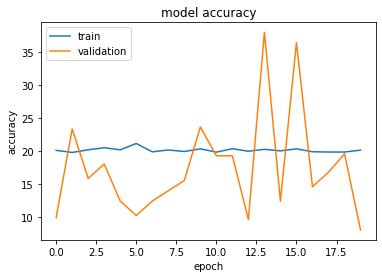

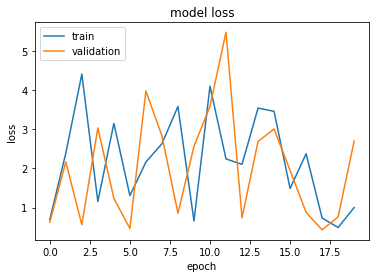

In [ ]:
# summarize history for accuracy
plt.plot(history_model_inception_v3['train accuracy'])
plt.plot(history_model_inception_v3['validation accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/Graphs/inception_v3_accuracy.png', \
            facecolor='white', edgecolor='none')
plt.show()


# summarize history for loss
plt.plot(history_model_inception_v3['train loss'])
plt.plot(history_model_inception_v3['validation loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/Graphs/inception_v3_loss.png', \
            facecolor='white', edgecolor='none')
plt.show()

In [ ]:
print(f'{(train_time/3600):.2f}')

1.81


In [ ]:
model_inception_v3 = torchvision.models.inception_v3(pretrained=True, aux_logits=False)
summary(model_inception_v3)

Layer (type:depth-idx)                   Param #
Inception3                               --
├─BasicConv2d: 1-1                       --
│    └─Conv2d: 2-1                       864
│    └─BatchNorm2d: 2-2                  64
├─BasicConv2d: 1-2                       --
│    └─Conv2d: 2-3                       9,216
│    └─BatchNorm2d: 2-4                  64
├─BasicConv2d: 1-3                       --
│    └─Conv2d: 2-5                       18,432
│    └─BatchNorm2d: 2-6                  128
├─MaxPool2d: 1-4                         --
├─BasicConv2d: 1-5                       --
│    └─Conv2d: 2-7                       5,120
│    └─BatchNorm2d: 2-8                  160
├─BasicConv2d: 1-6                       --
│    └─Conv2d: 2-9                       138,240
│    └─BatchNorm2d: 2-10                 384
├─MaxPool2d: 1-7                         --
├─InceptionA: 1-8                        --
│    └─BasicConv2d: 2-11                 --
│    │    └─Conv2d: 3-1                  12,288
│   

In [ ]:
y_pred_ls = []
y_test_ls = []
total = 0

with torch.no_grad():
  for b, (X_test, y_test) in enumerate(test_loader):
    y_test_ls.extend(y_test.tolist())
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # Apply the model
    y_test_pred = model_vgg16(X_test)

    # Tally the number of correct predictions
    predicted = torch.max(y_test_pred.data, 1)[1].tolist()
    y_pred_ls.extend(predicted)


In [ ]:
print(classification_report(y_pred_ls, y_test_ls))

              precision    recall  f1-score   support

           0       0.38      0.55      0.45        86
           1       0.58      0.63      0.60       158
           2       0.55      0.38      0.45        45
           3       0.22      0.36      0.27        25
           4       0.40      0.11      0.17        75

    accuracy                           0.46       389
   macro avg       0.42      0.40      0.39       389
weighted avg       0.47      0.46      0.44       389



20

## VIT for small datasets

In [ ]:
model_small_vit = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 5,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)
model_small_vit.to(device)

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=512, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedFor

In [ ]:
summary(model_small_vit)

Layer (type:depth-idx)                             Param #
ViT                                                101,376
├─SPT: 1-1                                         --
│    └─Sequential: 2-1                             --
│    │    └─Rearrange: 3-1                         --
│    │    └─LayerNorm: 3-2                         7,680
│    │    └─Linear: 3-3                            1,966,592
├─Dropout: 1-2                                     --
├─Transformer: 1-3                                 --
│    └─ModuleList: 2-2                             --
│    │    └─ModuleList: 3-4                        3,150,849
│    │    └─ModuleList: 3-5                        3,150,849
│    │    └─ModuleList: 3-6                        3,150,849
│    │    └─ModuleList: 3-7                        3,150,849
│    │    └─ModuleList: 3-8                        3,150,849
│    │    └─ModuleList: 3-9                        3,150,849
├─Identity: 1-4                                    --
├─Sequential: 1-5   

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_small_vit.parameters(),lr=0.001)
epochs = 30

In [ ]:
torch.cuda.empty_cache()
history_small_vit = train(model_small_vit, train_loader, val_loader, optimizer, criterion, epochs)

epoch: 0 loss: 1.383 train accuracy: 29.853 % val accuracy: 28.972 %
epoch: 1 loss: 1.428 train accuracy: 29.013 % val accuracy: 44.860 %
epoch: 2 loss: 1.506 train accuracy: 30.304 % val accuracy: 33.956 %
epoch: 3 loss: 1.523 train accuracy: 31.892 % val accuracy: 44.237 %
epoch: 4 loss: 1.461 train accuracy: 33.183 % val accuracy: 43.614 %
epoch: 5 loss: 1.528 train accuracy: 32.973 % val accuracy: 52.025 %
epoch: 6 loss: 1.490 train accuracy: 33.671 % val accuracy: 43.614 %
epoch: 7 loss: 1.379 train accuracy: 33.214 % val accuracy: 39.564 %
epoch: 8 loss: 1.577 train accuracy: 34.814 % val accuracy: 38.006 %
epoch: 9 loss: 1.377 train accuracy: 34.542 % val accuracy: 38.941 %
epoch: 10 loss: 1.428 train accuracy: 36.186 % val accuracy: 42.368 %
epoch: 11 loss: 1.425 train accuracy: 37.217 % val accuracy: 39.564 %
epoch: 12 loss: 1.323 train accuracy: 38.156 % val accuracy: 50.779 %
epoch: 13 loss: 1.278 train accuracy: 37.817 % val accuracy: 49.844 %
epoch: 14 loss: 1.350 train ac

In [ ]:
torch.save(model_small_vit, "/content/drive/MyDrive/models/small_vit.pth")

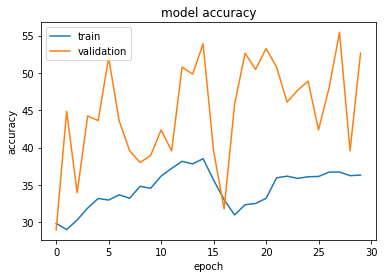

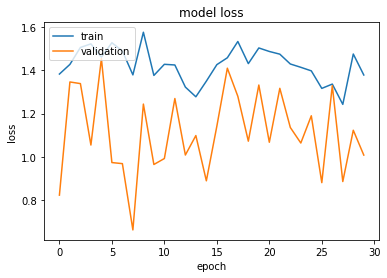

<Figure size 432x288 with 0 Axes>

In [ ]:
# summarize history for accuracy
plt.plot(history_small_vit['train accuracy'])
plt.plot(history_small_vit['validation accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/Graphs/small_vit-accuracy.png')

# summarize history for loss
plt.plot(history_small_vit['train loss'])
plt.plot(history_small_vit['validation loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/Graphs/small_vit-loss.png')

In [ ]:
import torch

In [ ]:
y_pred_ls = []
y_test_ls = []

model = torch.load('/content/drive/MyDrive/models/inception_v3.pth').to(device)

with torch.no_grad():
  for b, (X_test, y_test) in enumerate(test_loader):
    y_test_ls.extend(y_test.tolist())
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # Apply the model
    y_test_pred = model(X_test)

    # Tally the number of correct predictions
    predicted = torch.max(y_test_pred.data, 1)[1].tolist()
    y_pred_ls.extend(predicted)

with torch.no_grad():
  for b, (X_val, y_val) in enumerate(val_loader):
    y_test_ls.extend(y_val.tolist())
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    # Apply the model
    y_val_pred = model(X_val)

    # Tally the number of correct predictions
    predicted_val = torch.max(y_val_pred.data, 1)[1].tolist()
    y_pred_ls.extend(predicted_val)



In [ ]:
import mlxtend

In [ ]:
print(classification_report(y_pred_ls, y_test_ls))

              precision    recall  f1-score   support

           0       0.23      0.33      0.27       157
           1       0.26      0.41      0.32       194
           2       0.54      0.25      0.34       121
           3       0.23      0.17      0.20       101
           4       0.38      0.12      0.19       137

    accuracy                           0.28       710
   macro avg       0.33      0.26      0.26       710
weighted avg       0.32      0.28      0.27       710



In [ ]:
ls_0 = []
ls_1 = []
ls_2 = []
ls_3 = []
ls_4 = []
for (X_test, y_test) in test_loader:
  for i in y_test.tolist():
    if i == 0:
      ls_0.append(i)
    elif i ==1:
      ls_1.append(i)
    elif i == 2:
      ls_2.append(i)
    elif i == 3:
      ls_3.append(i)
    elif i == 4:
      ls_4.append(i)

In [ ]:
print(len(ls_0))
print(len(ls_1))
print(len(ls_2))
print(len(ls_3))
print(len(ls_4))

125
172
31
41
20


In [ ]:
model = torch.load('/content/drive/MyDrive/models/vit_b_16_fc2.pth')

In [ ]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [ ]:
!python --version

Python 3.7.13


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c329a39e-f2d8-b51d-1087-d3f6854412e2)
